# GP optimizer for one single hexapole

**Note**: In order to use it on a specific machine, you should build machine interface (setX and get_state functions).


In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import pickle
import numpy as np
from modules.bayes_optimization import BayesOpt, negUCB, negExpImprove
from modules.OnlineGP import OGP
import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import sys
import os
sys.path.insert(1, '/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/GPTrelated')
saveResultsQ = False
import scipy
import tensorflow as tf
from CorrectDefocus import CorrectDefocus

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
os.environ["CUDA_VISIBLE_DEVICES"]="0" # specify which GPU to use
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

### Creat the machine interface

In [3]:
ndim = 2 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation

dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
start_point = [[0.1 ,0.1]]

#creat machine interface
model_path = 'CNNmodels/VGG16_test13_attempt06.h5'
mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point, CNNoption = 1, CNNpath = model_path) 

Using TensorFlow backend.


Model loaded


In [4]:
# print(mi.x)
#check the reading objective is working
print(mi.getState())

/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Using CNN prediction.
saving ronchigram...
(array([[0.1, 0.1]]), array([[0.65093407]]))


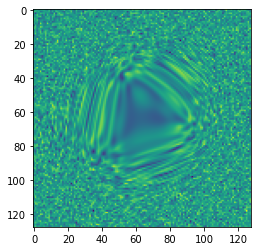

In [5]:
temp = np.load('ronchigram.npy')
plt.imshow(temp)

In [ ]:
#check noise std
y = [mi.getState()[1][0] for x in range(5)]
np.std(y)

### Create the gp

In [6]:
gp_ls = np.array(np.ones(ndim)) * [0.0671, 0.350]
gp_amp = 0.256 # default = 1
gp_noise = 0.0004  # default = 0.001
gp_precisionmat =  np.array(np.diag(1/(gp_ls**2)))

ndim = len(dev_ids)
hyperparams = {'precisionMatrix': gp_precisionmat, 'amplitude_covar': gp_amp, 'noise_variance': gp_noise} 
gp = OGP(ndim, hyperparams)

In [7]:
gp_ls

array([0.0671, 0.35  ])

### Create the BO

In [8]:
#create the bayesian optimizer that will use the gp as the model to optimize the machine 
opt = BayesOpt(gp, mi, acq_func="UCB", start_dev_vals = mi.x, dev_ids = dev_ids)
opt.ucb_params = np.array([0.002, 0.4])
opt.ucb_params = np.array([2, None])
opt.bounds = [(0,1),(0,1)]

Supposed to be grabbing initial machine state...
Using CNN prediction.
saving ronchigram...
x_init [[0.1 0.1]]
y_init [[0.65093407]]


**Running BO**

*run the gp search for some number of steps*

In [9]:
Obj_state_s=[]
Obj_state_s.append(mi.getState()[1][0])

Using CNN prediction.
saving ronchigram...


Text(0.5, 1.0, 'Neg UCB')

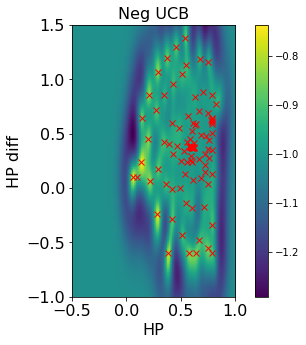

In [14]:
fig = plt.figure(figsize=(7,5))
x = np.linspace(-0.5,1,100) # array for H1
y = np.linspace(-1,1.5,100) # array for deltaH
UCB = np.zeros((100,100))

yval = UCB*0
yerr = UCB*0
for ix in range(len(x)):
    for iy in range(len(y)):
        UCB[iy,ix] = negUCB([x[ix],y[iy]],opt.model, 2, 0, 2, None)
        yval[iy,ix] = opt.model.predict(np.array([x[ix],y[iy]],ndmin=2))[0][0]

plt.subplot(111)
plt.imshow(UCB,origin='lower', extent=[-0.5,1,-1,1.5])
# plt.imshow(yval,origin='lower', extent=[0,1,0,1])
plt.plot(Status_array[:,0], Status_array[:,1],'x', c='r')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("HP", fontsize = 16)
plt.ylabel("HP diff", fontsize = 16)
plt.colorbar()
plt.title('Neg UCB', fontsize = 16)

In [15]:
np.save('HexapolesTest_UCB_2-0_Nbest3_Nstart2_Neval3_Nkeep2.npy', Status_array)

Using CNN prediction.
saving ronchigram...
iteration = 0
current position: [[0.1 0.1]] current best seen objective value: [0.65093407]


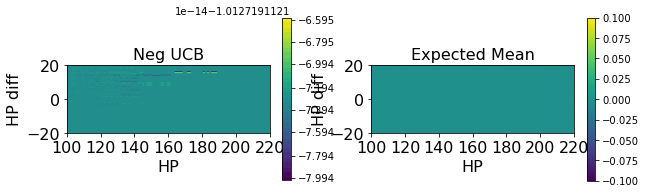

UnboundLocalError: local variable 'relative_bounds' referenced before assignment

In [10]:
# Test over single starting point
Niter = 100
Status_array = np.zeros([Niter + 1, 4]) # save the 
Status_array[0,0] = opt.current_x[0][0]
Status_array[0,1] = opt.current_x[0][1]
Status_array[0,2] = Status_array[0,3] = mi.getState()[1][0]
for i in range(Niter):
    
    print ('iteration =', i)
    print ('current position:', mi.x, 'current best seen objective value:', Obj_state_s[-1])
    
    # calculate UCB, model prediction, and plot part, only necessary when debugging.

    fig = plt.figure(figsize=(10,3))
    x = np.linspace(0,1,100)
    y = np.linspace(0,1,100)
    UCB = np.zeros((100,100))
    
    yval = UCB*0
    yerr = UCB*0
    for ix in range(len(x)):
        for iy in range(len(y)):
            UCB[ix,iy] = negUCB([x[ix],y[iy]],opt.model, 2, 0, 2, None)
            yval[ix,iy] = opt.model.predict(np.array([x[ix],y[iy]],ndmin=2))[0][0]
#             yerr[i,j] = opt.model.predict(np.array([x[i],y[j]],ndmin=2))[1][0]  # yerr matrix is not very helpful
            
    plt.subplot(121)
    plt.imshow(np.transpose(UCB),origin='lower', extent=[100,220,-20,20])
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel("HP", fontsize = 16)
    plt.ylabel("HP diff", fontsize = 16)
    plt.colorbar()
    plt.title('Neg UCB', fontsize = 16)
    
    plt.subplot(122)
    plt.imshow(np.transpose(yval),origin='lower', extent=[100,220,-20,20])
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel("HP", fontsize = 16)
    plt.ylabel("HP diff", fontsize = 16)
    plt.colorbar()
    plt.title('Expected Mean', fontsize = 16)
    
    plt.show()
#     End of plot part
    
#     fig = plt.figure(figsize=(4,4))
#     temp = np.load('ronchigram.npy')
#     plt.imshow(temp)
#     plt.show()
    
#     opt.OptIter()
    temp = opt.OptIter() # save the new acquisition point and objective value
    Obj_state_s.append(opt.best_seen()[1]) # save current best value
    Status_array[i+1, 3] = opt.best_seen()[1][0][0]  # best seen objective so far
    Status_array[i+1, 2] = temp[1][0][0]  # objective at new point
    Status_array[i+1, 0] = temp[0][0][0]  # coordinate of new point
    Status_array[i+1, 1] = temp[0][0][1]
print(opt.best_seen())

In [2]:
Status_array = np.load('HexapolesTest_UCB_2-0_Nbest3_Nstart2_Neval3_Nkeep2.npy')

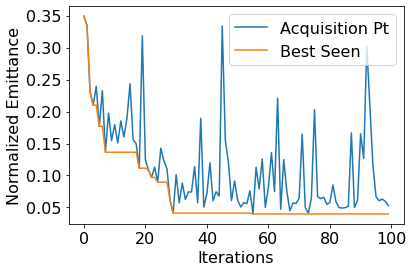

In [7]:
plt.subplot(111)
plt.plot(1-Status_array[0:-1,2],'-',c='C0', label = 'Acquisition Pt')
plt.plot(1-Status_array[0:-1,3],c='C1', label = 'Best Seen')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Iterations", fontsize = 16)
plt.ylabel("Normalized Emittance", fontsize = 16)
plt.legend(fontsize = 16)

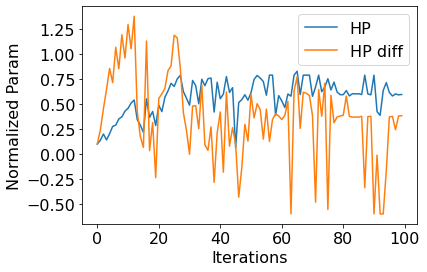

In [3]:
plt.subplot(111)
plt.plot(Status_array[0:-1,0],'-',c='C0', label = 'HP')
plt.plot(Status_array[0:-1,1],c='C1', label = 'HP diff')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Iterations", fontsize = 16)
plt.ylabel("Normalized Param", fontsize = 16)
plt.legend(fontsize = 16)

[[0.76990499 0.53862286]]
Using GPT output.
(array([[0.76990499, 0.53862286]]), array([[-27.38918451]]))


(-0.5, 127.5, 127.5, -0.5)

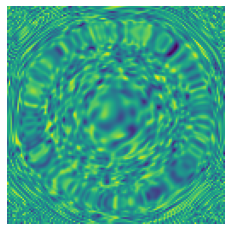

In [12]:
start_point = [opt.best_seen()[0]]
# start_point = [[899,0.1]]
mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point)
print(mi.x)
print(mi.getState())
temp = np.load('ronchigram.npy')
plt.imshow(temp)
plt.axis('off')

Text(0, 0.5, '$\\Delta$ H')

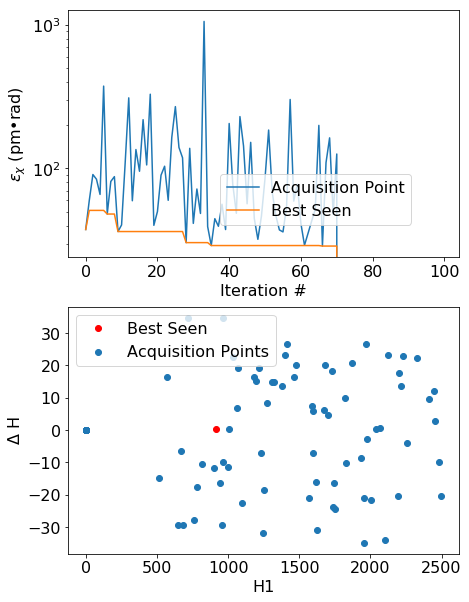

In [26]:
fig = plt.figure(figsize = (7,10))

plt.subplot(211)
plt.plot(-Status_array[0:-1,2],'-',c='C0', label = 'Acquisition Point')
plt.plot(-Status_array[0:-1,3],c='C1', label = 'Best Seen')
plt.yscale('log')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.legend(fontsize=16, loc='lower left')
plt.legend(fontsize=16, bbox_to_anchor=[0.9, 0.1],loc = 'lower right')
plt.xlabel('Iteration #', fontsize = 16)
plt.ylabel('$\epsilon_\chi$ (pm\u2022rad)', fontsize=16)

plt.subplot(212)
# plt.plot(Status_array[:,0], Status_array[:,1])
plt.scatter(Status_array[:,0], Status_array[:,1], label = 'Acquisition Points')
plt.plot(9.12390263e+02,0.242782767,'ro',c='r', label = 'Best Seen')
# plt.xlim([-10,10])
# plt.ylim([-10,10])
plt.legend(fontsize = 16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('H1', fontsize = 16)
plt.ylabel('$\Delta$ H', fontsize = 16)

In [ ]:
np.save('4xOBJ_1245_-32_UCB_2-0_100iter.npy',Status_array)

## Test different random starting points

In [6]:
# Test over multiple different starting point
# total number of test points and number of iterations within each test
Niter = 100
Ntest_point = 30

# Range for two parameters
H1_range = [500, 2000]
H2_range = [-35, 35]
# Obj_list = np.zeros((Ntest_point, Niter + 3))
Obj_list = np.load('DiffStarPointTest_newGPT_4xOBJ_150iter_30pts.npy')

for itest in range(Ntest_point):
    rs = np.random.RandomState()
    count = itest
    
    # If this row is filled, skip this loop
    if Obj_list[count,Niter+2] != 0:
        continue

    start_point = [[H1_range[0] + rs.rand()*(H1_range[1] - H1_range[0]), 
                    H2_range[0] + rs.rand()*(H2_range[1] - H2_range[0])]]
    
    # For each starting point, create a new mi with the new start_point par, then a new opt to connect to the new mi
    mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) 
    gp_ls = np.array(np.ones(ndim)) * [1.580, 11.44]
    gp_amp = 2750.1
    gp_noise = 1.80e-4

    gp_precisionmat =  np.array(np.diag(1/(gp_ls**2)))
    hyps = [gp_precisionmat, np.log(gp_amp), np.log(gp_noise**2)] #format the hyperparams for the OGP

    gp = OGP(ndim, hyps,prmean=0)

    opt = BayesOpt(gp, mi, acq_func="UCB", start_dev_vals = mi.x, dev_ids = dev_ids)
    opt.ucb_params = np.array([2, None])
    Obj_list[count,0] = start_point[0][0]  # starting points
    Obj_list[count,1] = start_point[0][1]
    Obj_list[count,2] = mi.getState()[1][0]  # initial state
    print('Start point: ' + str(start_point[0][0]) + ', ' + str(start_point[0][1]))
    for i in range(Niter):
        opt.OptIter()
        Obj_list[count,i+3] = opt.best_seen()[1]  # save the best objective in each iteration
        print('Iteration ' + str(i)+ ' finished, best seen value: ' + str(Obj_list[count, i+3]))
        np.save('DiffStarPointTest_newGPT_4xOBJ_150iter_30pts.npy',Obj_list)

#         clear_output(wait=True)
#         fig = plt.figure(figsize = (7,5))
#         for i in range(itest):
#             temp = -Obj_list[i,2::]
#             plt.plot(temp[2::], '-',c='C0')
        
#         plt.show()
#         plt.xticks(fontsize=20)
#         plt.yticks(fontsize=20)
#         plt.tick_params(direction='in')
#         plt.xlabel('Iteration #', fontsize = 20)
#         plt.ylabel('$\epsilon_\chi$ (pm$\u2022$rad)', fontsize = 20)

target_func =  <machine_interfaces.machine_interface_GPT.machine_interface object at 0x7f4c1e493be0>
********* BO - self.mi = self.target_func wORKED!
Supposed to be grabbing initial machine state...
x_init [[944.50987969  32.98353294]]
y_init [[-206.48466438]]
Using prior mean function of  0
Using prior mean parameters of  None
Start point: 944.5098796858889, 32.983532937238024
New State: [[694.63820224  -1.53062129]], [[-213.0391185]]
Iteration 0 finished, best seen value: -206.48466437835071
New State: [[1846.66294525   10.73139116]], [[-39.48549456]]
Iteration 1 finished, best seen value: -39.485494555050394
New State: [[810.92076784   5.27067794]], [[-177.44241078]]
Iteration 2 finished, best seen value: -39.485494555050394
New State: [[623.29113189  19.71890495]], [[-285.76848231]]
Iteration 3 finished, best seen value: -39.485494555050394
New State: [[1542.92122707   11.25515686]], [[-57.29359485]]
Iteration 4 finished, best seen value: -39.485494555050394
New State: [[1598.6527

New State: [[1136.90995986   29.75804898]], [[-148.83610936]]
Iteration 65 finished, best seen value: -34.55577577754948
New State: [[ 1.07429490e+03 -2.91002446e-01]], [[-113.18993469]]
Iteration 66 finished, best seen value: -34.55577577754948
New State: [[1103.86478628   34.72266375]], [[-168.15307876]]
Iteration 67 finished, best seen value: -34.55577577754948
New State: [[632.40025127   5.5971002 ]], [[-238.9248278]]
Iteration 68 finished, best seen value: -34.55577577754948
New State: [[1884.01619438  -21.15721753]], [[-48.05952979]]
Iteration 69 finished, best seen value: -34.55577577754948
New State: [[1027.33183728  -13.45783533]], [[-135.48667353]]
Iteration 70 finished, best seen value: -34.55577577754948
New State: [[875.37093138  33.57665252]], [[-233.15974029]]
Iteration 71 finished, best seen value: -34.55577577754948
New State: [[1347.34218104    7.36099536]], [[-73.7286994]]
Iteration 72 finished, best seen value: -34.55577577754948
New State: [[602.40996981   4.802100

New State: [[1.47686141e+03 1.01657141e+00]], [[-56.58010155]]
Iteration 30 finished, best seen value: -34.452440441201055
New State: [[829.11379827 -25.41765497]], [[-228.63941269]]
Iteration 31 finished, best seen value: -34.452440441201055
New State: [[9.77992015e+02 1.98525608e-01]], [[-132.80464979]]
Iteration 32 finished, best seen value: -34.452440441201055
New State: [[1627.88901014  -20.03082179]], [[-61.7464188]]
Iteration 33 finished, best seen value: -34.452440441201055
New State: [[841.18368451 -23.14540788]], [[-215.28115087]]
Iteration 34 finished, best seen value: -34.452440441201055
New State: [[1342.1136606    -4.48764247]], [[-72.84307783]]
Iteration 35 finished, best seen value: -34.452440441201055
New State: [[898.97764345 -14.15560766]], [[-170.49137882]]
Iteration 36 finished, best seen value: -34.452440441201055
New State: [[994.86760475   8.40474724]], [[-133.46209721]]
Iteration 37 finished, best seen value: -34.452440441201055
New State: [[1982.37008286  -22.

New State: [[1977.51579716   14.65862892]], [[-40.27320623]]
Iteration 98 finished, best seen value: -29.878930957552605
New State: [[730.09286978 -23.12950198]], [[-262.33973439]]
Iteration 99 finished, best seen value: -29.878930957552605
target_func =  <machine_interfaces.machine_interface_GPT.machine_interface object at 0x7f4c1e091d30>
********* BO - self.mi = self.target_func wORKED!
Supposed to be grabbing initial machine state...
x_init [[857.16800777  -7.29415435]]
y_init [[-168.05879917]]
Using prior mean function of  0
Using prior mean parameters of  None
Start point: 857.1680077704739, -7.294154345353842
New State: [[1296.02116585  -34.6258361 ]], [[-134.22153867]]
Iteration 0 finished, best seen value: -134.22153867425044
New State: [[ 1.16186069e+03 -3.06979046e-01]], [[-97.73402228]]
Iteration 1 finished, best seen value: -97.73402228164171
New State: [[1142.92539538   23.29669476]], [[-130.80487089]]
Iteration 2 finished, best seen value: -97.73402228164171
New State: [[

New State: [[1574.54285117  -22.86297853]], [[-71.10276962]]
Iteration 63 finished, best seen value: -29.106479946915012
New State: [[1965.18652139    2.9440915 ]], [[-30.37440893]]
Iteration 64 finished, best seen value: -29.106479946915012
New State: [[763.24131386  -1.20869699]], [[-189.82613323]]
Iteration 65 finished, best seen value: -29.106479946915012
New State: [[782.91846181 -28.48202667]], [[-264.15763221]]
Iteration 66 finished, best seen value: -29.106479946915012
New State: [[886.12380178  30.81238856]], [[-218.99356845]]
Iteration 67 finished, best seen value: -29.106479946915012
New State: [[1393.71756782  -34.11704323]], [[-116.948138]]
Iteration 68 finished, best seen value: -29.106479946915012
New State: [[1107.08090258  -10.31101928]], [[-115.04599952]]
Iteration 69 finished, best seen value: -29.106479946915012
New State: [[1279.6447579   -34.87168515]], [[-138.78674331]]
Iteration 70 finished, best seen value: -29.106479946915012
New State: [[1062.85197244   12.89

New State: [[1627.48236144  -32.41670748]], [[-84.47343775]]
Iteration 28 finished, best seen value: -29.567141402783445
New State: [[1858.47964587    5.21543661]], [[-34.10764035]]
Iteration 29 finished, best seen value: -29.567141402783445
New State: [[594.44692627 -33.49208998]], [[-1330.21537297]]
Iteration 30 finished, best seen value: -29.567141402783445
New State: [[528.68569806  -5.38955959]], [[-290.79713564]]
Iteration 31 finished, best seen value: -29.567141402783445
New State: [[739.61728245  -1.89501408]], [[-197.93119474]]
Iteration 32 finished, best seen value: -29.567141402783445
New State: [[989.08316634   2.97712916]], [[-131.00274228]]
Iteration 33 finished, best seen value: -29.567141402783445
New State: [[645.5861522    3.67405859]], [[-231.14077445]]
Iteration 34 finished, best seen value: -29.567141402783445
New State: [[1082.25473517   20.90407397]], [[-137.30650036]]
Iteration 35 finished, best seen value: -29.567141402783445
New State: [[1703.84195777  -27.163

New State: [[1788.24693138  -17.553556  ]], [[-46.74039748]]
Iteration 96 finished, best seen value: -29.567141402783445
New State: [[1543.91129519   29.93903033]], [[-89.16137748]]
Iteration 97 finished, best seen value: -29.567141402783445
New State: [[1151.34348219  -15.71297625]], [[-115.66717026]]
Iteration 98 finished, best seen value: -29.567141402783445
New State: [[580.71351196  22.14206651]], [[-326.56926425]]
Iteration 99 finished, best seen value: -29.567141402783445
target_func =  <machine_interfaces.machine_interface_GPT.machine_interface object at 0x7f4c1e091d68>
********* BO - self.mi = self.target_func wORKED!
Supposed to be grabbing initial machine state...
x_init [[1243.48954159    2.30829637]]
y_init [[-84.9526393]]
Using prior mean function of  0
Using prior mean parameters of  None
Start point: 1243.489541593177, 2.3082963725875203
New State: [[1867.2020103   -13.18199361]], [[-38.55446195]]
Iteration 0 finished, best seen value: -38.55446194613831
New State: [[71

New State: [[1671.83563842  -10.90404383]], [[-46.05565771]]
Iteration 62 finished, best seen value: -29.955812466084907
New State: [[1964.4000709   -32.35437663]], [[-61.1946796]]
Iteration 63 finished, best seen value: -29.955812466084907
New State: [[1634.5924668    13.82989209]], [[-54.54681404]]
Iteration 64 finished, best seen value: -29.955812466084907
New State: [[1558.66437768    9.77510352]], [[-55.45648573]]
Iteration 65 finished, best seen value: -29.955812466084907
New State: [[1963.96445676    7.9614908 ]], [[-33.51640514]]
Iteration 66 finished, best seen value: -29.955812466084907
New State: [[1131.16158941   29.55214038]], [[-148.99159408]]
Iteration 67 finished, best seen value: -29.955812466084907
New State: [[1450.23515711  -22.03031228]], [[-82.91431121]]
Iteration 68 finished, best seen value: -29.955812466084907
New State: [[1080.04508921  -22.27017335]], [[-144.89613522]]
Iteration 69 finished, best seen value: -29.955812466084907
New State: [[1304.48626203   16

New State: [[1587.23868452  -28.7256179 ]], [[-81.1808669]]
Iteration 27 finished, best seen value: -31.371075324709064
New State: [[ 1.09931616e+03 -7.13331380e-01]], [[-108.38810373]]
Iteration 28 finished, best seen value: -31.371075324709064
New State: [[1861.69544163   11.07580489]], [[-39.33824953]]
Iteration 29 finished, best seen value: -31.371075324709064
New State: [[1506.5665467   -34.18685199]], [[-102.19300891]]
Iteration 30 finished, best seen value: -31.371075324709064
New State: [[609.76532094  34.4828364 ]], [[-540.64614132]]
Iteration 31 finished, best seen value: -31.371075324709064
New State: [[660.64927146 -33.04487094]], [[-460.01921773]]
Iteration 32 finished, best seen value: -31.371075324709064
New State: [[1913.29212214   29.73769002]], [[-63.68886683]]
Iteration 33 finished, best seen value: -31.371075324709064
New State: [[817.67160923  26.01916909]], [[-225.10632121]]
Iteration 34 finished, best seen value: -31.371075324709064
New State: [[1975.03133419    

New State: [[1425.56947484   11.23292674]], [[-69.49506656]]
Iteration 95 finished, best seen value: -31.371075324709064
New State: [[652.96766393 -31.41637488]], [[-447.05249974]]
Iteration 96 finished, best seen value: -31.371075324709064
New State: [[899.36492755 -12.64940387]], [[-165.79500939]]
Iteration 97 finished, best seen value: -31.371075324709064
New State: [[916.7138272   25.69464824]], [[-191.24529212]]
Iteration 98 finished, best seen value: -31.371075324709064
New State: [[824.3584701    6.85652837]], [[-175.33334338]]
Iteration 99 finished, best seen value: -31.371075324709064
target_func =  <machine_interfaces.machine_interface_GPT.machine_interface object at 0x7f4c1e0914e0>
********* BO - self.mi = self.target_func wORKED!
Supposed to be grabbing initial machine state...
x_init [[1261.71314309  -23.3881836 ]]
y_init [[-112.68252307]]
Using prior mean function of  0
Using prior mean parameters of  None
Start point: 1261.7131430949814, -23.388183603503105
New State: [[

New State: [[1301.91931185   -6.17046474]], [[-79.09878953]]
Iteration 61 finished, best seen value: -29.268278640346374
New State: [[1065.43078735   23.33322919]], [[-145.41662547]]
Iteration 62 finished, best seen value: -29.268278640346374
New State: [[917.05467398  20.93525056]], [[-175.92558335]]
Iteration 63 finished, best seen value: -29.268278640346374
New State: [[1338.31434976  -27.26515931]], [[-108.41126642]]
Iteration 64 finished, best seen value: -29.268278640346374
New State: [[1531.64563392   -4.31995903]], [[-52.10825468]]
Iteration 65 finished, best seen value: -29.268278640346374
New State: [[1190.56479867   22.35093666]], [[-118.7463865]]
Iteration 66 finished, best seen value: -29.268278640346374
New State: [[1030.11323549  -25.37599189]], [[-164.35980891]]
Iteration 67 finished, best seen value: -29.268278640346374
New State: [[1049.31073422  -15.17846086]], [[-134.09848748]]
Iteration 68 finished, best seen value: -29.268278640346374
New State: [[1100.29015727   

New State: [[1498.12290964  -19.9695087 ]], [[-73.92829862]]
Iteration 26 finished, best seen value: -30.36995283219156
New State: [[805.52796831   8.89987257]], [[-183.17748253]]
Iteration 27 finished, best seen value: -30.36995283219156
New State: [[574.04033355  14.22070086]], [[-288.92747239]]
Iteration 28 finished, best seen value: -30.36995283219156
New State: [[1.20616779e+03 6.75003109e-01]], [[-90.61443257]]
Iteration 29 finished, best seen value: -30.36995283219156
New State: [[759.89862722 -28.22613037]], [[-272.95351226]]
Iteration 30 finished, best seen value: -30.36995283219156
New State: [[1868.91356457  -12.6682147 ]], [[-37.95248669]]
Iteration 31 finished, best seen value: -30.36995283219156
New State: [[863.12083192  -3.55582481]], [[-162.20667555]]
Iteration 32 finished, best seen value: -30.36995283219156
New State: [[1.86251313e+03 1.25549866e+00]], [[-32.07683577]]
Iteration 33 finished, best seen value: -30.36995283219156
New State: [[925.15299499 -31.84222981]]

New State: [[724.38400464  -9.41532071]], [[-214.0094373]]
Iteration 94 finished, best seen value: -29.883724554225704
New State: [[858.08824606  35.        ]], [[-244.92708916]]
Iteration 95 finished, best seen value: -29.883724554225704
New State: [[1754.37852652   26.67844842]], [[-65.67511149]]
Iteration 96 finished, best seen value: -29.883724554225704
New State: [[1117.92626204  -12.45294429]], [[-116.54613078]]
Iteration 97 finished, best seen value: -29.883724554225704
New State: [[1123.78690496    4.79331206]], [[-104.5974122]]
Iteration 98 finished, best seen value: -29.883724554225704
New State: [[1478.05479399   13.63320037]], [[-67.44305941]]
Iteration 99 finished, best seen value: -29.883724554225704
target_func =  <machine_interfaces.machine_interface_GPT.machine_interface object at 0x7f4c1e091630>
********* BO - self.mi = self.target_func wORKED!
Supposed to be grabbing initial machine state...
x_init [[1478.09428652   33.66287529]]
y_init [[-103.50397502]]
Using prior 

New State: [[1.15335059e+03 2.58792602e-01]], [[-98.76399303]]
Iteration 59 finished, best seen value: -29.617214607544664
New State: [[924.65083116  26.96857397]], [[-192.47412748]]
Iteration 60 finished, best seen value: -29.617214607544664
New State: [[881.46785845  -8.88933741]], [[-163.62566494]]
Iteration 61 finished, best seen value: -29.617214607544664
New State: [[1397.08004147   29.75470202]], [[-105.08868104]]
Iteration 62 finished, best seen value: -29.617214607544664
New State: [[1208.92082038  -12.27738812]], [[-99.58447866]]
Iteration 63 finished, best seen value: -29.617214607544664
New State: [[628.74893609  -5.2733394 ]], [[-242.14043945]]
Iteration 64 finished, best seen value: -29.617214607544664
New State: [[1.35213616e+03 7.76765511e-01]], [[-70.42747545]]
Iteration 65 finished, best seen value: -29.617214607544664
New State: [[1291.86433821  -22.8716357 ]], [[-106.20595167]]
Iteration 66 finished, best seen value: -29.617214607544664
New State: [[1631.63105836   

New State: [[861.11209215 -19.74608892]], [[-196.17694652]]
Iteration 24 finished, best seen value: -42.49607838681711
New State: [[912.26781968 -35.        ]], [[-236.801344]]
Iteration 25 finished, best seen value: -42.49607838681711
New State: [[1310.66608783   11.45993578]], [[-83.22504918]]
Iteration 26 finished, best seen value: -42.49607838681711
New State: [[1374.47469581  -18.15138997]], [[-84.24612069]]
Iteration 27 finished, best seen value: -42.49607838681711
New State: [[1974.21499171  -34.37681311]], [[-64.227693]]
Iteration 28 finished, best seen value: -42.49607838681711
New State: [[615.72950693  16.96263316]], [[-277.849109]]
Iteration 29 finished, best seen value: -42.49607838681711
New State: [[554.4860762   17.22499366]], [[-315.05994643]]
Iteration 30 finished, best seen value: -42.49607838681711
New State: [[523.13109223  17.58370327]], [[-692.47751389]]
Iteration 31 finished, best seen value: -42.49607838681711
New State: [[1347.75787484  -30.84406207]], [[-115.

New State: [[1187.62296073  -35.        ]], [[-158.20778136]]
Iteration 92 finished, best seen value: -30.462705631511007
New State: [[1034.83000016   -9.5546333 ]], [[-127.4354991]]
Iteration 93 finished, best seen value: -30.462705631511007
New State: [[704.35478101   1.66748182]], [[-208.78247341]]
Iteration 94 finished, best seen value: -30.462705631511007
New State: [[1861.26109113  -17.72608982]], [[-43.93795797]]
Iteration 95 finished, best seen value: -30.462705631511007
New State: [[516.41950136  -6.88640714]], [[-302.70595998]]
Iteration 96 finished, best seen value: -30.462705631511007
New State: [[1098.99992408  -11.75897092]], [[-118.57139496]]
Iteration 97 finished, best seen value: -30.462705631511007
New State: [[587.78164108  33.02631873]], [[-811.87888524]]
Iteration 98 finished, best seen value: -30.462705631511007
New State: [[853.25139284  -3.96071561]], [[-164.43649542]]
Iteration 99 finished, best seen value: -30.462705631511007
target_func =  <machine_interfaces

New State: [[934.68577329 -25.15749879]], [[-191.56776391]]
Iteration 58 finished, best seen value: -30.18127539133469
New State: [[1197.71311383   31.16417068]], [[-139.44076971]]
Iteration 59 finished, best seen value: -30.18127539133469
New State: [[1782.56355256   27.7062797 ]], [[-66.78736342]]
Iteration 60 finished, best seen value: -30.18127539133469
New State: [[893.85670988  33.43610024]], [[-225.76361249]]
Iteration 61 finished, best seen value: -30.18127539133469
New State: [[1506.54067705  -22.54499328]], [[-77.92540654]]
Iteration 62 finished, best seen value: -30.18127539133469
New State: [[1892.38226701   14.50311855]], [[-42.39100356]]
Iteration 63 finished, best seen value: -30.18127539133469
New State: [[ 1.66208595e+03 -1.44096192e+00]], [[-40.76513613]]
Iteration 64 finished, best seen value: -30.18127539133469
New State: [[835.49382217   2.10042564]], [[-167.52013357]]
Iteration 65 finished, best seen value: -30.18127539133469
New State: [[1903.750452     14.024816

New State: [[1121.67677898   31.49946918]], [[-155.6305647]]
Iteration 24 finished, best seen value: -30.153099159290555
New State: [[1689.88211485   -6.62623245]], [[-41.2939624]]
Iteration 25 finished, best seen value: -30.153099159290555
New State: [[1330.3908041    26.30345484]], [[-106.47768503]]
Iteration 26 finished, best seen value: -30.153099159290555
New State: [[1625.29922453  -19.08493531]], [[-60.24703365]]
Iteration 27 finished, best seen value: -30.153099159290555
New State: [[1889.19341347   -6.87438235]], [[-32.45615374]]
Iteration 28 finished, best seen value: -30.153099159290555
New State: [[1212.80945596   11.96792937]], [[-98.08919598]]
Iteration 29 finished, best seen value: -30.153099159290555
New State: [[1449.81455812  -32.79140892]], [[-105.5134788]]
Iteration 30 finished, best seen value: -30.153099159290555
New State: [[1536.53536143  -17.30039893]], [[-65.46928716]]
Iteration 31 finished, best seen value: -30.153099159290555
New State: [[589.59723599 -24.74

New State: [[1484.96563105    7.33056101]], [[-59.13542075]]
Iteration 92 finished, best seen value: -30.153099159290555
New State: [[1906.00961752   12.07566554]], [[-38.31817362]]
Iteration 93 finished, best seen value: -30.153099159290555
New State: [[565.43272531 -35.        ]], [[-1573.4496505]]
Iteration 94 finished, best seen value: -30.153099159290555
New State: [[1758.92455749   32.65879262]], [[-75.57772335]]
Iteration 95 finished, best seen value: -30.153099159290555
New State: [[994.99295371   2.5340896 ]], [[-128.7301046]]
Iteration 96 finished, best seen value: -30.153099159290555
New State: [[1777.92628458   -6.99517803]], [[-36.47568693]]
Iteration 97 finished, best seen value: -30.153099159290555
New State: [[1274.63669979   10.20209405]], [[-86.84696331]]
Iteration 98 finished, best seen value: -30.153099159290555
New State: [[1785.93364269   23.60298863]], [[-59.40437155]]
Iteration 99 finished, best seen value: -30.153099159290555
target_func =  <machine_interfaces.

New State: [[1342.40288033   21.08371586]], [[-93.95127379]]
Iteration 57 finished, best seen value: -32.17809700702983
New State: [[1220.07558395  -35.        ]], [[-150.13355836]]
Iteration 58 finished, best seen value: -32.17809700702983
New State: [[1439.63745249  -26.52943695]], [[-92.63200352]]
Iteration 59 finished, best seen value: -32.17809700702983
New State: [[829.20113684  -1.12070703]], [[-170.09147637]]
Iteration 60 finished, best seen value: -32.17809700702983
New State: [[1142.01902118  -28.13568093]], [[-147.02970973]]
Iteration 61 finished, best seen value: -32.17809700702983
New State: [[524.43117921   7.54364956]], [[-293.2528809]]
Iteration 62 finished, best seen value: -32.17809700702983
New State: [[1295.3110261     4.16269768]], [[-78.47863852]]
Iteration 63 finished, best seen value: -32.17809700702983
New State: [[1582.27304931   12.74800652]], [[-56.6113819]]
Iteration 64 finished, best seen value: -32.17809700702983
New State: [[1969.52284117  -20.40952697]]

/home/chenyu/Desktop/GaussianProcess/GPTrelated/uscope_calc.py:124: UserWarning: loadtxt: Empty input file: "outscope.txt"
  screen =  np.loadtxt(ASCIIFILE, skiprows=5)


BayesOpt - ERROR: Could not grab initial machine state
Using prior mean function of  0
Using prior mean parameters of  None
Start point: 622.8186752597273, -29.16918566801651


AttributeError: 'BayesOpt' object has no attribute 'Y_obs'

## Plot results of parameter test

In [7]:
print(Obj_list[:,1])

[-18.27074204  30.70304144  26.31387135 -17.43042198 -10.41775638
  14.13660307   0.62278277  34.01880702   6.12956854  32.98353294
 -19.15136945  -7.29415435  24.02718981   2.30829637   4.68280282
 -23.3881836   30.73131492  33.66287529  -0.77735363  32.39922709
  31.67234735 -15.70723898 -29.16918567   0.           0.
   0.           0.           0.           0.           0.        ]


Text(0, 0.5, '$\\epsilon_\\chi$ (pm$•$rad)')

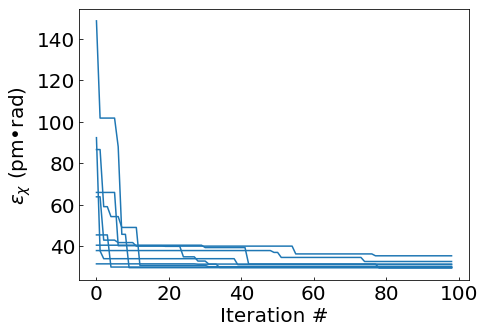

In [8]:
Obj_list = np.load('DiffStarPointTest_newGPT_4xOBJ_150iter_30pts.npy')

fig = plt.figure(figsize = (7,5))
for i in range(9):
    temp = -Obj_list[i,2::]
    plt.plot(temp[2::], '-',c='C0')
# Plot part of the results
#     plt.plot(np.linspace(60,101,41),temp[60::],'-',c='C0')
    
# plt.yscale('log')
# plt.axhline(y = 0.039, c='red', linewidth = 2, label = 'grid search')
# plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.title('GPy with new UCB parameter', fontsize=20)
plt.tick_params(direction='in')
plt.xlabel('Iteration #', fontsize = 20)
plt.ylabel('$\epsilon_\chi$ (pm$\u2022$rad)', fontsize = 20)

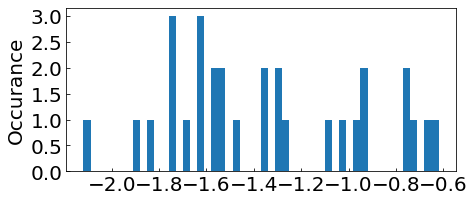

In [25]:
fig = plt.figure(figsize = (7,3))
_ = plt.hist(np.log(-np.asarray(Obj_list)[:,-1]), bins = 50)  # arguments are passed to np.histogram
# plt.title("Histogram with 'auto' bins")
plt.yticks(fontsize=20)
# plt.xticks([])
plt.xticks(fontsize=20)
plt.ylabel('Occurance', fontsize = 20)
plt.tick_params(direction='in')
plt.show()

## Scan Test
Test a series of different values for the hexapoles to determine the noise and magnitute that should be used for the GP.
<br>The calculated emittance vs hexpole current can also be used as a reference for the real objective function during the GP test.

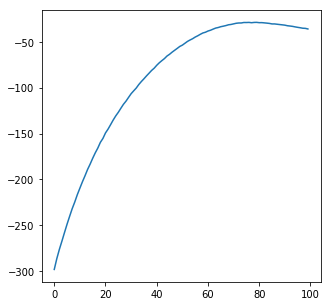

In [11]:
# 1D scan along for H1 value with deltaH=0
ndim = 2 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation
dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
H1_list = np.linspace(500,2500,num=100)
emit_profile = np.zeros([100,1])

for i in range(len(H1_list)):
    start_point = [[H1_list[i], 0]] 
    mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
    mi = mi_module.machine_interface(dev_ids = dev_ids, st-+art_point = start_point) #an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background noise with std dev = 0.1
    emit_profile[i] = (mi.getState()[1][0])
    print(H1_list[i], emit_profile[i])
    
    clear_output(wait=True)
    fig = plt.figure(figsize = [5,5])
    plt.plot(emit_profile)
    plt.show()
    np.save('S1_500_2500_100steps_emittance.npy',emit_profile)

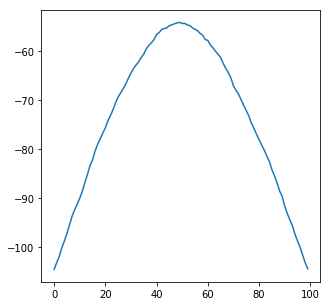

35.0 [[1498, 35.0]] [-104.40404326]


In [8]:
# 1D scan along for deltaH value with H1=1498
ndim = 2 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation
dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
deltaH_list = np.linspace(-35, 35,num=100)
emit_profile = np.zeros([100,1])

for i in range(len(deltaH_list)):
    start_point = [[1498, deltaH_list[i]]] 
    print(start_point)
    mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
    mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) #an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background noise with std dev = 0.1
    emit_profile[i] = (mi.getState()[1][0])
    
    clear_output(wait=True)
    fig = plt.figure(figsize = [5,5])
    plt.plot(emit_profile)
    plt.show()
    np.save('deltaH_-35_35_100steps_emittance.npy',emit_profile)
    print(deltaH_list[i], start_point, emit_profile[i])

1500.0 35.0 -14.051603875127887


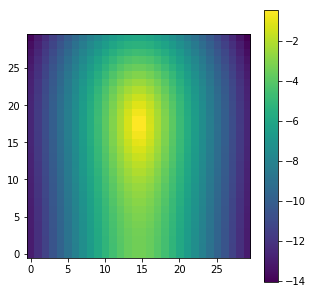

In [3]:
# 2D parameter scan for all (hex1, hex2) pairs
ndim = 2 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation
dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
hex_list = np.linspace(0,1500,num=30)
hex_diff_list = np.linspace(-35,35,num=30)
emit_matrix = np.zeros([30, 30])

for i in range(len(hex_list)):
    for j in range(len(hex_diff_list)):

        start_point = [[hex_list[i],hex_diff_list[j]]]  # use H1 = H2 = 25 as default start, following Cameron's setup
        mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
        mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) #an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background noise with std dev = 0.1
        emit_matrix[i,j] = mi.getState()[1][0]
        
        clear_output(wait=True)
        print(hex_list[i], hex_diff_list[j], emit_matrix[i,j])
        fig = plt.figure(figsize = [5,5])
        plt.imshow(emit_matrix, origin='lower')
        plt.colorbar()
        plt.show()
        fig.savefig('2Dscan_0-1500_-35-35_H1_H2.png')
        np.save('2Dscan_0-1500_-35-35_H1_H2.npy',emit_matrix)

## Aux Functions

## Previously used scripts

In [ ]:
# Test over multiple different starting point
Niter = 30
Ntest_point = 100  # total number of test points
H1_range = [-9.9,9.9]
H2_range = [-9.9,9.9]
# Obj_list = np.zeros((Ntest_point, Niter + 3))
Obj_list = np.load('DiffStarPointTest_symmetric_GPy_30iter_100pts_newUCB_2.npy')

for itest in range(Ntest_point):
    rs = np.random.RandomState()
    count = itest
    if Obj_list[count,Niter+2] != 0:
        continue
#     start_point = [[H1_list[i1],H2_list[i2]]]
    start_point = [[H1_range[0] + rs.random()*(H1_range[1] - H1_range[0]), 
                    H2_range[0] + rs.random()*(H2_range[1] - H2_range[0])]]
    # For each starting point, create a new mi with the new start_point par, then a new opt to connect to the new mi
    mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) 
    gp_ls = np.array(np.ones(ndim)) * 1.30
    gp_amp = 4.30e5
    gp_noise = 5.91-5

    gp_precisionmat =  np.array(np.diag(1/(gp_ls**2)))
    hyps = [gp_precisionmat, np.log(gp_amp), np.log(gp_noise**2)] #format the hyperparams for the OGP

    gp = OGP(ndim, hyps,prmean=0)

    opt = BayesOpt(gp, mi, acq_func="UCB", start_dev_vals = mi.x, dev_ids = dev_ids)
    opt.ucb_params = np.array([0.002, 0.4])
    Obj_list[count,0] = start_point[0][0]  # starting points
    Obj_list[count,1] = start_point[0][1]
    Obj_list[count,2] = mi.getState()[1][0]  # initial state

    for i in range(Niter):
        opt.OptIter()
        Obj_list[count,i+3] = opt.best_seen()[1]  # save the best objective in each iteration
#             Obj_state_s.append(opt.best_seen()[1])
    print(str(start_point[0][0]) + ', ' + str(start_point[0][1]) + ', ' + str(itest) + ' Finished.')
    np.save('DiffStarPointTest_symmetric_GPy_30iter_100pts_newUCB_2.npy',Obj_list)

target_func =  <machine_interfaces.machine_interface_GPT.machine_interface object at 0x7f08c849aa90>
********* BO - self.mi = self.target_func wORKED!
Supposed to be grabbing initial machine state...
x_init [[4.81600442 6.37932927]]
y_init [[-5024745.37945339]]
Using prior mean function of  0
Using prior mean parameters of  None
single-processing, minimize, x_start = [4.767205381248891, 5.922320219568654]
(<modules.OnlineGP.OGP object at 0x7f08c849ab00>, 2, 2, 0.002, 0.4)
Minimizing finished, min point = [4.76720538 5.92232022]
New State: [[4.76720538 5.92232022]], [[-5377726.71525058]]
single-processing, minimize, x_start = [5.1466979956407535, 6.654674887804203]
(<modules.OnlineGP.OGP object at 0x7f08c849ab00>, 2, 3, 0.002, 0.4)
Minimizing finished, min point = [10. 10.]
New State: [[10. 10.]], [[-1395169.03032541]]
single-processing, minimize, x_start = [9.594518764984743, 10.384725217541362]
(<modules.OnlineGP.OGP object at 0x7f08c849ab00>, 2, 4, 0.002, 0.4)
Minimizing finished, mi

New State: [[ 0.33530885 -0.39421839]], [[-76423.34055197]]
4.816004424192354, 6.379329273373836, 12 Finished.
target_func =  <machine_interfaces.machine_interface_GPT.machine_interface object at 0x7f08ce1425c0>
********* BO - self.mi = self.target_func wORKED!
Supposed to be grabbing initial machine state...
x_init [[ 5.67704269 -3.1385417 ]]
y_init [[-583452.68820212]]
Using prior mean function of  0
Using prior mean parameters of  None
single-processing, minimize, x_start = [5.645981755637314, -3.2699405326291253]
(<modules.OnlineGP.OGP object at 0x7f08c8c6e9e8>, 2, 2, 0.002, 0.4)
Minimizing finished, min point = [ 5.64598176 -3.26994053]
New State: [[ 5.64598176 -3.26994053]], [[-540467.05494135]]
single-processing, minimize, x_start = [5.8120984664150255, -3.0786765457162177]
(<modules.OnlineGP.OGP object at 0x7f08c8c6e9e8>, 2, 3, 0.002, 0.4)
Minimizing finished, min point = [10. 10.]
New State: [[10. 10.]], [[-1395169.03032541]]
single-processing, minimize, x_start = [5.412348553

New State: [[-0.32942992  0.32022591]], [[-75209.7828379]]
5.677042685067738, -3.138541702642523, 13 Finished.
target_func =  <machine_interfaces.machine_interface_GPT.machine_interface object at 0x7f08ce14cd68>
********* BO - self.mi = self.target_func wORKED!
Supposed to be grabbing initial machine state...
x_init [[-3.28354145  9.66132846]]
y_init [[-2211528.20199262]]
Using prior mean function of  0
Using prior mean parameters of  None
single-processing, minimize, x_start = [-3.671732391411346, 9.390088116145929]
(<modules.OnlineGP.OGP object at 0x7f08c85febe0>, 2, 2, 0.002, 0.4)
Minimizing finished, min point = [-3.67173239  9.39008812]
New State: [[-3.67173239  9.39008812]], [[-1376663.91880119]]
single-processing, minimize, x_start = [-3.350507839520609, 9.629163178960896]
(<modules.OnlineGP.OGP object at 0x7f08c85febe0>, 2, 3, 0.002, 0.4)
Minimizing finished, min point = [10. 10.]
New State: [[10. 10.]], [[-1395169.03032541]]
single-processing, minimize, x_start = [-3.596545662

In [4]:
# Test over multiple different starting point
Niter = 30
Ntest_point = 70  # total number of test points
H1_range = [-9.9,9.9]
H2_range = [-9.9,9.9]
Obj_list = np.zeros((Ntest_point, Niter + 3))
# Obj_list = np.load('DiffStarPointTest_symmetric_MIX_30iter_100pts_pt2.npy')

for itest in range(Ntest_point):
    rs = np.random.RandomState()
    count = itest
    if Obj_list[count,Niter+2] != 0:
        continue
#     start_point = [[H1_list[i1],H2_list[i2]]]
    start_point = [[H1_range[0] + rs.random()*(H1_range[1] - H1_range[0]), 
                    H2_range[0] + rs.random()*(H2_range[1] - H2_range[0])]]
    # For each starting point, create a new mi with the new start_point par, then a new opt to connect to the new mi
    mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) 
    gp_ls = np.array(np.ones(ndim)) * 3.01
    gp_amp = 4.3e5
    gp_noise = 5.91e-5

    gp_precisionmat =  np.array(np.diag(1/(gp_ls**2)))
    hyps = [gp_precisionmat, np.log(gp_amp), np.log(gp_noise**2)] #format the hyperparams for the OGP

    gp = OGP(ndim, hyps,prmean=0)

    opt = BayesOpt(gp, mi, acq_func="UCB", start_dev_vals = mi.x, dev_ids = dev_ids)
    opt.ucb_params = np.array([2, None])
    Obj_list[count,0] = start_point[0][0]  # starting points
    Obj_list[count,1] = start_point[0][1]
    Obj_list[count,2] = mi.getState()[1][0]  # initial state

    for i in range(Niter):
        opt.OptIter()
        Obj_list[count,i+3] = opt.best_seen()[1]  # save the best objective in each iteration
#             Obj_state_s.append(opt.best_seen()[1])
    print(str(start_point[0][0]) + ', ' + str(start_point[0][1]) + ', ' + str(itest) +' Finished.')
    np.save('DiffStarPointTest_symmetric_MIX_30iter_100pts_pt2.npy',Obj_list)

target_func =  <machine_interfaces.machine_interface_GPT.machine_interface object at 0x7faea009aa20>
********* BO - self.mi = self.target_func wORKED!
Supposed to be grabbing initial machine state...


/nfs/user/cz489/venv/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/nfs/user/cz489/venv/lib64/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


x_init [[ 7.78916819 -0.10489326]]
y_init [[-3175931.54846069]]
Using prior mean function of  0
Using prior mean parameters of  None
[ 7.78916819 -0.10489326] [[-3175931.54846069]]
[ 7.78916819 -0.10489326]
single-processing, minimize, x_start = [7.531519369471605, 0.33616900742945177]
Minimizing finished, min point = [7.53151937 0.33616901]
New State: [[7.53151937 0.33616901]], [[-3466370.9103576]]
[ 7.78916819 -0.10489326] [[-3175931.54846069]]
[ 7.78916819 -0.10489326]
single-processing, minimize, x_start = [8.16533929525702, 0.3851766939696064]
Minimizing finished, min point = [10. 10.]
New State: [[10. 10.]], [[-1395169.03032541]]
[10. 10.] [[-1395169.03032541]]
[10. 10.]
single-processing, minimize, x_start = [10.487616663231114, 9.865004175040227]
Minimizing finished, min point = [ 10. -10.]
New State: [[ 10. -10.]], [[-680048.39400609]]
[ 10. -10.] [[-680048.39400609]]
[ 10. -10.]
single-processing, minimize, x_start = [9.542750835351612, -9.54215728180615]
Minimizing finished,

New State: [[ 7.62344188 10.        ]], [[-1084748.34835629]]
[ 5.02152917 -5.48558279] [[-279156.86844163]]
[ 5.02152917 -5.48558279]
single-processing, minimize, x_start = [4.871568363092299, -5.571765030191298]
Minimizing finished, min point = [-3.37893471  1.08817408]
New State: [[-3.37893471  1.08817408]], [[-456670.28725052]]
[ 5.02152917 -5.48558279] [[-279156.86844163]]
[ 5.02152917 -5.48558279]
single-processing, minimize, x_start = [5.294803967435487, -5.288612923778563]
Minimizing finished, min point = [10.          0.60993252]
New State: [[10.          0.60993252]], [[-5362769.67088749]]
[ 5.02152917 -5.48558279] [[-279156.86844163]]
[ 5.02152917 -5.48558279]
single-processing, minimize, x_start = [4.945142235095531, -4.993159344007736]
Minimizing finished, min point = [ -0.10728128 -10.        ]
New State: [[ -0.10728128 -10.        ]], [[-5769861.19556153]]
[ 5.02152917 -5.48558279] [[-279156.86844163]]
[ 5.02152917 -5.48558279]
single-processing, minimize, x_start = [5.0

## Test behavior of the negative UCB function and scipy.optimize.minimize

In [8]:
print(opt.OptIter())
# print('negUCB = ' + str(negUCB([4.0,4.0], opt.model, 1, 0)))
# print(opt.model.predict(np.array([4.9,4.9],ndmin=2)))

[7.9 7.1] [[-924053.03617951]]
[7.9 7.1]
single-processing, minimize, x_start = [0, 0]
Minimizing finished, min point = [0. 0.]
New State: [[0. 0.]], [[-76330.25573556]]
(array([[0., 0.]]), array([[-76330.25573556]]))


In [9]:
opt.acq_func[0]

'UCB'

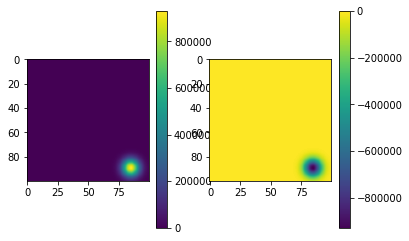

In [10]:
x = np.linspace(-10,10,100)
y = np.linspace(-10,10,100)
UCB = np.zeros((100,100))
yval = UCB*0
yerr = UCB*0
for i in range(len(x)):
    for j in range(len(y)):
        UCB[i,j] = negUCB([x[i],y[j]],opt.model, 1, 0)
        yval[i,j] = opt.model.predict(np.array([x[i],y[j]],ndmin=2))[0][0]
        yerr[i,j] = opt.model.predict(np.array([x[i],y[j]],ndmin=2))[1][0]
plt.subplot(121)
plt.imshow(UCB)
plt.colorbar()
plt.subplot(122)
plt.imshow(yval)
plt.colorbar()

In [21]:
bnds = [(-10, 10),(-10,10)]
x0 = [7.901, 7.1]
x0 = [x + 0.001 for x in x0]
ndim = 2
nsteps = 1
nu = 2
delta = None
res = scipy.optimize.minimize(negUCB, x0, args=(opt.model, ndim, nsteps, nu, delta), 
                              method='L-BFGS-B',tol=1e-4,bounds=bnds,options={'maxiter':1000})     
print(res.x)

[10. 10.]


In [19]:
len(x0)

2

In [30]:
negUCB([7.899,7.099],opt.model, 1, 0, 2, None)

931715.8967290218